In [1]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm
# ! pip install -U pyLDAvis

In [2]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2022-12-31 22:22:14.884024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')

# Temporarily using first 100 news only
# df = df[:200]
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [4]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

# Comibining News Heading and Body
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [5]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Form Trigrams
    data_words_trigrams = make_trigrams(data_words_bigrams)
    
    return data_words_trigrams

In [10]:
data_preprocessed = preprocess(data_words)
df['clean'] = data_preprocessed

df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rues, decision, grant, extension, baj..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treated,..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, officials, martyred, nowshera,..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal_miners, killed, gas, explosion, harnai, ..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throws, joint, petition, perks, kp, teach..."


# VISUALIZE CLEANED UP DATASET

In [11]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

print("Word Count Total:", len(list_of_words))
# Obtain the total number of unique words
print("Word Count Unique:", len(list(set(list_of_words))))

Word Count Total: 617554
Word Count Unique: 33126


<AxesSubplot: xlabel='count', ylabel='Topic'>

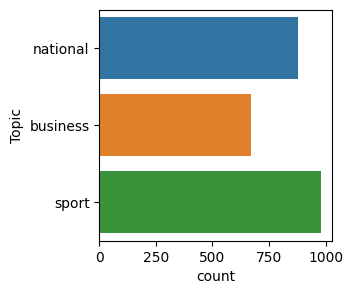

In [12]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

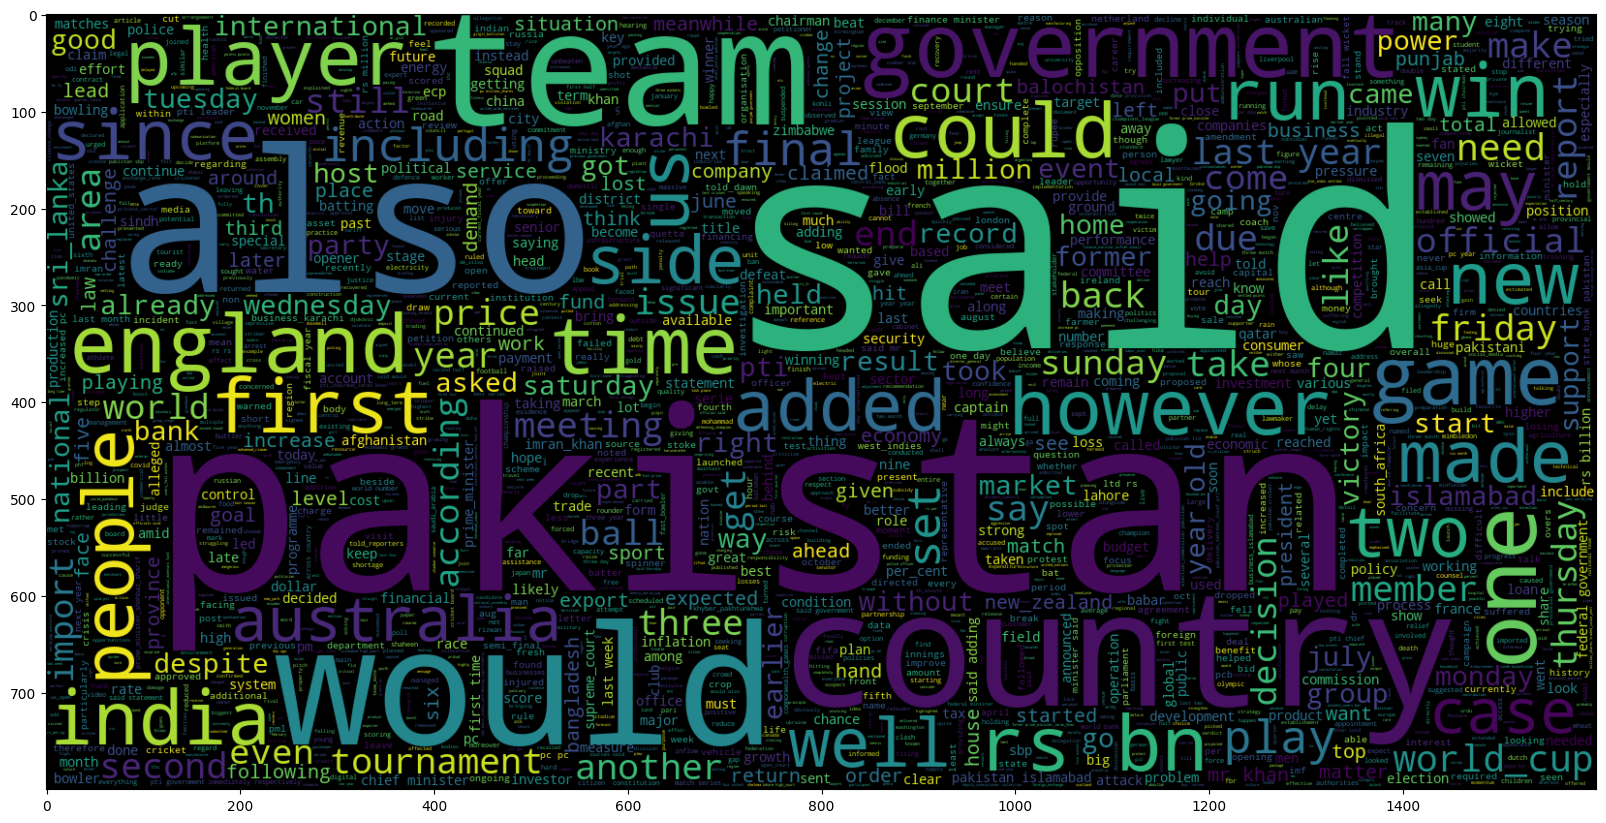

In [13]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [14]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 763


# FEATURE EMBEDDING USING BAG OF WORDS

In [25]:
id2word = corpora.Dictionary(data_preprocessed)

bow_corpus = []
for text in data_preprocessed:
    new = id2word.doc2bow(text)
    bow_corpus.append(new)

# print ("BOW News1:\n",bow_corpus[0])
# firstword = id2word[[0][:1][0]]
# print (firstword)

df['BOW'] = bow_corpus

df.head()


,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean,clean_joined,BOW
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rues, decision, grant, extension, baj...",qaiser rues decision grant extension bajwa isl...,"[(0, 2), (1, 2), (2, 3), (3, 1), (4, 2), (5, 1..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treated,...",imran could opted suicide_attack treated like ...,"[(7, 1), (12, 1), (31, 2), (44, 1), (54, 4), (..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, officials, martyred, nowshera,...",three police officials martyred nowshera gun a...,"[(0, 1), (7, 1), (11, 2), (12, 2), (37, 1), (8..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal_miners, killed, gas, explosion, harnai, ...",coal_miners killed gas explosion harnai pakist...,"[(0, 1), (1, 1), (11, 1), (12, 1), (30, 1), (8..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throws, joint, petition, perks, kp, teach...",sc throws joint petition perks kp teachers pak...,"[(12, 1), (30, 1), (37, 3), (44, 1), (80, 2), ..."


# LDA TOPIC MODELLING

In [26]:
TOPIC_COUNT = 3

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=TOPIC_COUNT,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [27]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.098329  0.211770       1        1  35.633061
0      0.107020 -0.172518       2        1  35.050250
1     -0.205349 -0.039252       3        1  29.316689, topic_info=           Term         Freq        Total Category  logprob  loglift
880          pc  2830.000000  2830.000000  Default  30.0000  30.0000
699          rs  2443.000000  2443.000000  Default  29.0000  29.0000
946          bn  1625.000000  1625.000000  Default  28.0000  28.0000
72          pti  1772.000000  1772.000000  Default  27.0000  27.0000
37   government  3200.000000  3200.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
52       months   448.498859   701.885441   Topic3  -6.0006   0.7791
745     million   440.431042   641.071297   Topic3  -6.0188   0.8516
864         may   429.316268   885.708652   Topic3  -6.0443   0.5028
562         day   432.830113  1371.942345   Topic3  -6.0362   0.0734
40      however   421.014670   936.205209   Topic3  -6.0638   0.4278

[212 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
210       2  0.998965      alleged
211       1  0.213558         also
211       2  0.490773         also
211       3  0.295353         also
2328      2  0.996053  appointment
...     ...       ...          ...
107       1  0.326487         year
107       2  0.063905         year
107       3  0.609552         year
206       1  0.982945     year_old
206       2  0.016692     year_old

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])